#### Integrantes
- Jean Paul Huby Tuesta (100%)
- Luis Eduardo Chahua Salgueran (100%)
- Andres Jaffet Riveros Soto (100%)

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
from tqdm import tqdm
from pytorchtools import EarlyStopping
from livelossplot import PlotLosses
from torchvision import transforms, models
from collections import OrderedDict
torch.manual_seed(42)

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print("Data:")
    print('Devices available:',torch.cuda.device_count()) 
    print('Current Devices available:', torch.cuda.current_device() ) 

Using device: cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.1 GB
Cached:    2.7 GB
Data:
Devices available: 1
Current Devices available: 0


In [84]:
label_map ={
    0 : "Normal",
    1 : "Covid",
    2 : "Lung Opacity",
    3 : "Viral Pneumonia"
}

In [85]:
masks_pwd = ["COVID-19_Radiography_Dataset/Normal/masks/*","COVID-19_Radiography_Dataset/COVID/masks/*", 
"COVID-19_Radiography_Dataset/Lung_Opacity/masks/*","COVID-19_Radiography_Dataset/Viral_Pneumonia/masks/*"]
images_pwd = ["COVID-19_Radiography_Dataset/Normal/images/*","COVID-19_Radiography_Dataset/COVID/images/*", 
"COVID-19_Radiography_Dataset/Lung_Opacity/images/*","COVID-19_Radiography_Dataset/Viral_Pneumonia/images/*"]
image_paths = []
labels = []
mask_paths = []
for i, (folder_img_path, folder_mask_path) in enumerate(zip(images_pwd, masks_pwd)):
    for f_path, m_path in zip(glob(folder_img_path), glob(folder_mask_path)):
        
        image_paths.append(f_path)
        mask_paths.append(m_path)
        labels.append(i)

print("Images: ", len(image_paths), ", Labels: ", len(labels), ", Masks: " ,len(mask_paths))

Images:  21165 , Labels:  21165 , Masks:  21165


In [86]:
transform = transforms.Compose([transforms.ToTensor()])

In [87]:
class PulmonesDataset:
    def __init__(self, img_paths, img_labels, img_masks):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.img_masks = img_masks
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        PULMON_IMAGE = Image.open(self.img_paths[index]).convert('L') # Convierte gray-scale
        #MASK_IMAGE = Image.open(self.img_masks[index]).resize(PULMON_IMAGE.size).convert('L')
        #blank = PULMON_IMAGE.point(lambda _:0) # Totalmente Negro
        #PULMON_SEGMENTED = Image.composite(PULMON_IMAGE, blank, MASK_IMAGE)
        TENSOR_IMAGE = transform(PULMON_IMAGE)
        label = self.img_labels[index]
        return TENSOR_IMAGE, label

In [89]:
dataset = PulmonesDataset(image_paths, labels, mask_paths)

In [90]:
dataset_indices = list(range(0, len(dataset)))
dataset_labels = labels
train_indices, test_indices = train_test_split(dataset_indices, test_size=0.3, random_state = 1, stratify= dataset_labels )

test_labels = [dataset_labels[idx] for idx in test_indices]
validate_indices, test_indices = train_test_split(test_indices, test_size = 0.33, random_state = 1, stratify= test_labels)
print(f"Number of training examples: {len(train_indices)}")
print(f"Number of validation examples: {len(validate_indices)}")
print(f"Number of test examples: {len(test_indices)}")

Number of training examples: 14815
Number of validation examples: 4254
Number of test examples: 2096


In [91]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validate_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Preparing Data Loader Objects

In [92]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset, batch_size= BATCH_SIZE, sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=validation_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler= test_sampler)

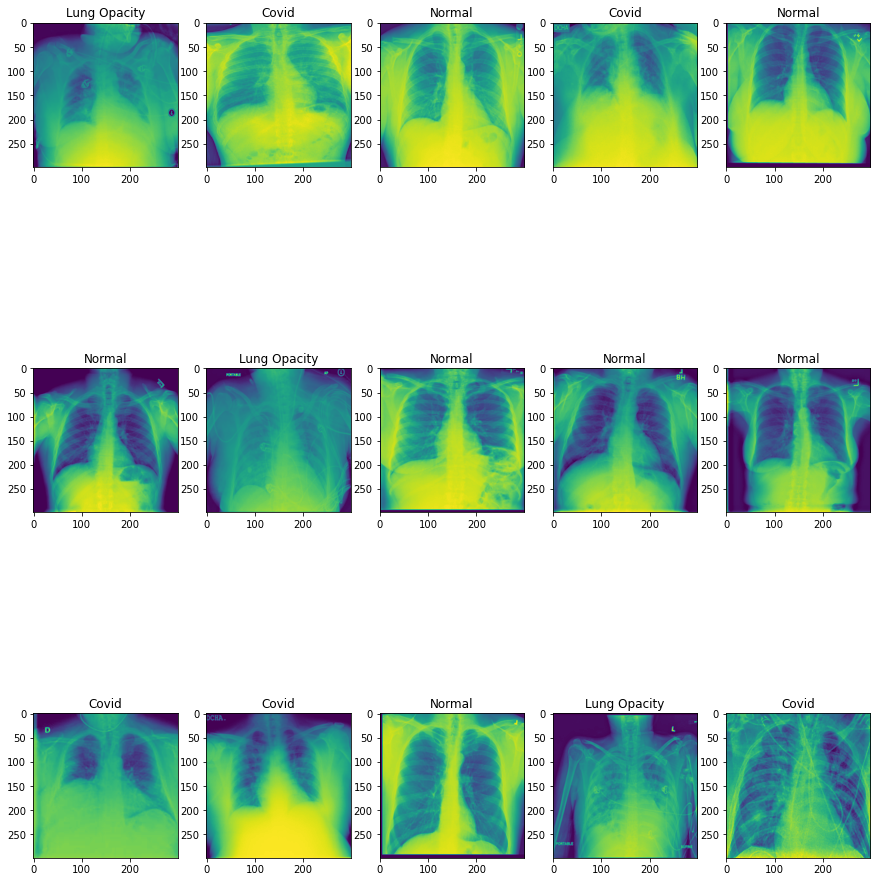

In [93]:
images, labels = next(iter(train_loader))
fig, axis= plt.subplots(3, 5, figsize=(15, 18))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[int(labels[i])]
        ax.imshow(npimg)
        ax.set(title=f"{label}")
        

In [94]:
def get_composition(index_lst: list, test_name = "generic"):
    counter = {}
    for label in label_map:
        counter[label_map[label]] = 0

    for inx in index_lst:
        label = dataset_labels[inx]
        counter[label_map[label] ] += 1

    return pd.DataFrame.from_dict(counter, orient= 'index', columns= [test_name]) / len(index_lst)


distSet = [ (train_indices, "train"), (validate_indices,"validate") , (test_indices,"test")]
df_lst = [ get_composition(idx, name) for idx, name in distSet]
df_dst = pd.concat( df_lst, axis = 1) 

df_dst 

,train,validate,test
Normal,0.481539,0.481664,0.481393
Covid,0.170840,0.170898,0.170802
Lung Opacity,0.284036,0.283968,0.284351
Viral Pneumonia,0.063584,0.063470,0.063454


In [95]:
def getAccuracy(model, loader):
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      return 100 * correct / total

In [96]:
num_classes = 4
learning_rate = 0.001
num_epochs = 20

In [97]:
def trainEarlyStopping(model, optimizer, loss_fn, num_epochs, patience = 4):
  # train the model
  liveplot= PlotLosses()
  loss_lst = []
  val_loss_lst = []
  early_stopping = EarlyStopping(patience=patience, verbose=True)

  for epoch in tqdm(range(num_epochs), desc = "Training model..."):
    logs = {}
    epoch_total = 0.
    validation_total = 0.
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_total += loss.item()
      
    with torch.set_grad_enabled(False):
      for i, (images, labels) in enumerate(validation_loader):
        # Transfer to GPU
        images = images.to(device)
        labels = labels.to(device)
        # forward 
        output = model(images)
        loss   = loss_fn(output, labels)

        validation_total += loss.item()
        
    logs["accuracy"] = getAccuracy(model, train_loader)
    logs["val_accuracy"] = getAccuracy(model, validation_loader)
    
    logs["loss"] = epoch_total / len(train_loader)
    logs["val_loss"] = validation_total /  len(validation_loader)
    loss = epoch_total / len(train_loader)
    val_loss = validation_total /  len(validation_loader)
    #logs["loss"] , logs["val_loss"] = loss, val_loss
    loss_lst.append(loss)
    val_loss_lst.append(val_loss)

    liveplot.update(logs)
    liveplot.send()

    early_stopping(val_loss = val_loss, model = model)
    if early_stopping.early_stop:
      print("Early stopping")
      break

  model.load_state_dict(torch.load('checkpoint.pt'))            
  return model, loss_lst, val_loss_lst

In [98]:
def showEarly(train_loss, valid_loss):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(max(train_loss), max(valid_loss))) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

In [99]:
def train(model, optimizer, loss_fn, num_epochs):
    loss_lst = []
    val_loss_lst = []
    running_loss =0.0
    # train the model
    total_step = len(train_loader)

    liveplot= PlotLosses()

    for epoch in range(num_epochs):
        logs = {}
        epoch_total = 0.
        validation_total = 0.
        j = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # forward 
            output = model(images)
            loss   = loss_fn(output, labels)
            # change the params
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_total += loss.item()
            j+=1

        
        with torch.set_grad_enabled(False):
            for i, (images, labels) in enumerate(validation_loader):
                # Transfer to GPU
                images = images.to(device)
                labels = labels.to(device)
                # forward 
                output = model(images)
                loss   = loss_fn(output, labels)

                validation_total += loss.item()

        logs["accuracy"] = getAccuracy(model, train_loader)
        logs["val_accuracy"] = getAccuracy(model, validation_loader)
        
        logs["loss"] = epoch_total / len(train_loader)
        logs["val_loss"] = validation_total /  len(validation_loader)
        val_loss = validation_total /  len(validation_loader)
        loss_lst.append(loss)
        val_loss_lst.append(val_loss)
        liveplot.update(logs)
        liveplot.send()
              
    print('Finished Training Trainset')
    return model, loss_lst, val_loss_lst

### -------------------------------------------------------------------------------------------------------------

### CNN - SIN CAPAS ADICIONALES

In [42]:
class CNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 129 | 150
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 129 // 2 = 64 (mask) | 75
        )
        self.fc = nn.Linear(75*75*32, num_classes) # 64 * 64 * 32 (mask) | 75 * 75 * 32

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [45]:
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print([ e.shape  for e in model.fc.parameters()])
model.fc.weight


[torch.Size([4, 180000]), torch.Size([4])]


Parameter containing:
tensor([[-2.1046e-03,  1.9298e-03,  3.9120e-04,  ...,  1.9458e-03,
         -4.2865e-04, -1.9419e-03],
        [-1.7626e-03, -3.7871e-04,  7.4897e-05,  ...,  1.4838e-03,
          2.2404e-03, -1.7984e-03],
        [ 1.9612e-03,  1.9865e-03,  1.5280e-03,  ..., -4.7965e-04,
          5.3852e-04, -7.5699e-04],
        [ 1.2980e-03, -3.8569e-05,  1.3815e-03,  ..., -1.8121e-03,
          1.7140e-03,  2.2348e-03]], device='cuda:0', requires_grad=True)

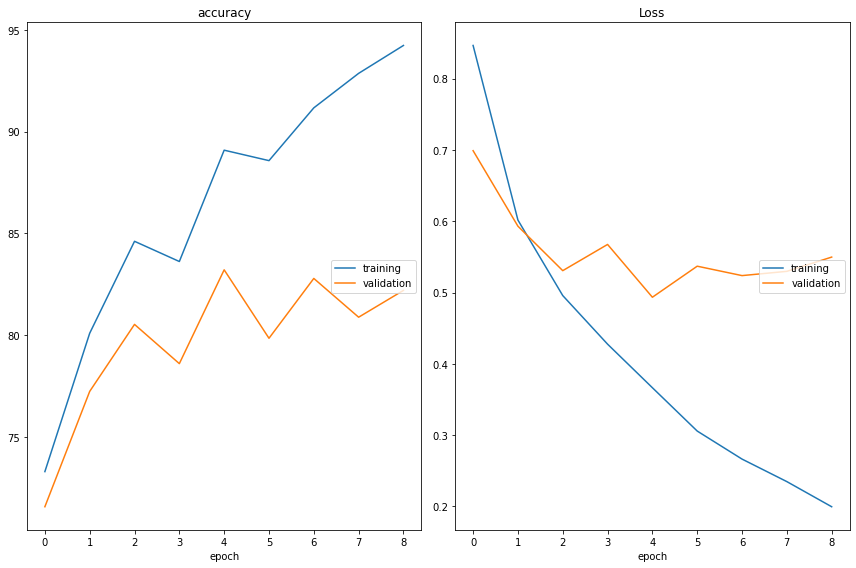

Training model...:  40%|████      | 8/20 [17:57<26:55, 134.65s/it]

accuracy
	training         	 (min:   73.304, max:   94.236, cur:   94.236)
	validation       	 (min:   71.580, max:   83.216, cur:   82.205)
Loss
	training         	 (min:    0.200, max:    0.847, cur:    0.200)
	validation       	 (min:    0.493, max:    0.699, cur:    0.550)
EarlyStopping counter: 4 out of 4
Early stopping


In [46]:
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model, optimizer, loss_fn, num_epochs)

In [47]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")


Validation: 83.21579689703808
Test: 83.34923664122137


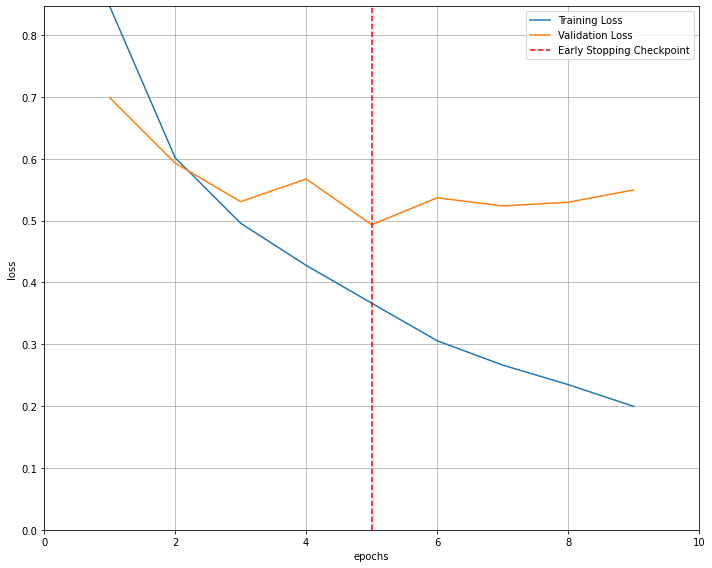

In [50]:
showEarly(loss_lst, val_loss_lst)

### CNN - SIN CAPA ADICIONAL - BATCH NORMALIZATION

In [51]:
class CNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
            nn.BatchNorm2d(32)
        )
        self.fc = nn.Linear(75*75*32, num_classes) # 64 * 64 * 32 (mask) | 75 * 75 * 32

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


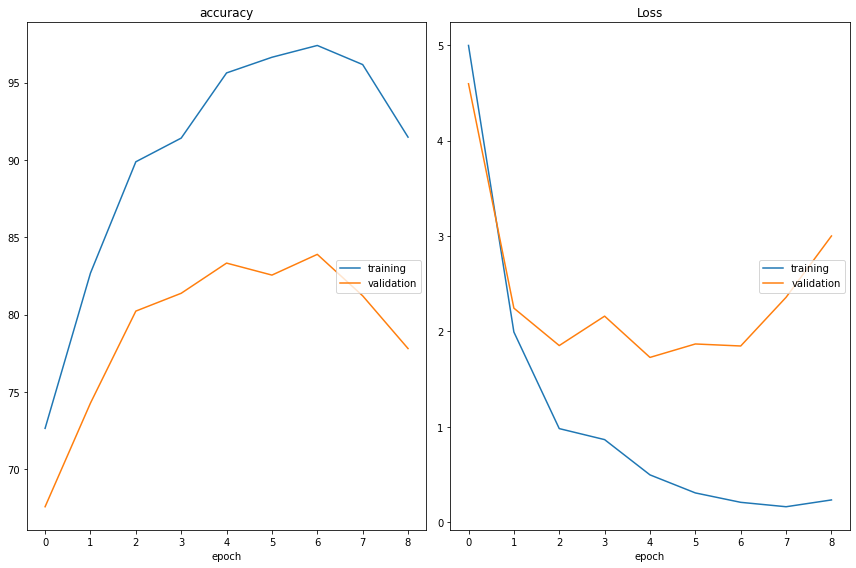

Training model...:  40%|████      | 8/20 [18:06<27:10, 135.84s/it]

accuracy
	training         	 (min:   72.649, max:   97.401, cur:   91.475)
	validation       	 (min:   67.583, max:   83.898, cur:   77.809)
Loss
	training         	 (min:    0.164, max:    4.997, cur:    0.235)
	validation       	 (min:    1.728, max:    4.596, cur:    3.001)
EarlyStopping counter: 4 out of 4
Early stopping


In [52]:
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print([ e.shape  for e in model.fc.parameters()])
model.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model, optimizer, loss_fn, num_epochs)


In [53]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

Validation: 83.12176774800189
Test: 83.15839694656489


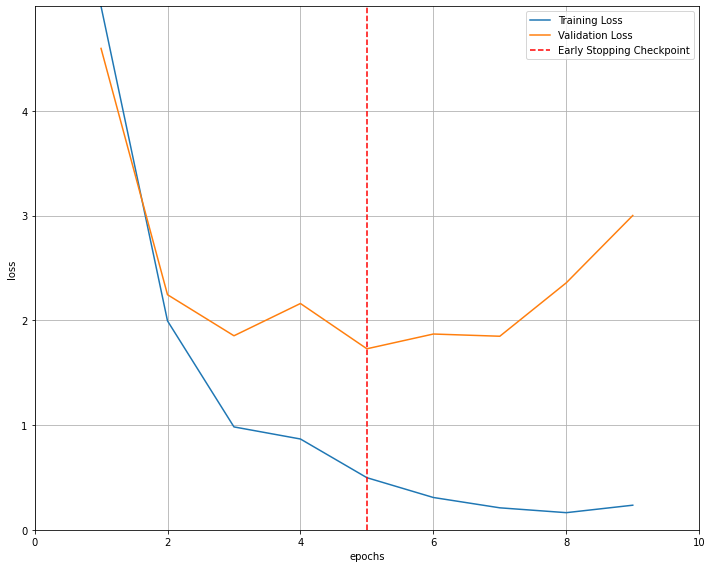

In [54]:
showEarly(loss_lst, val_loss_lst)

### CNN - SIN CAPAS ADICIONALES - BATCH Y DROPOUT

In [59]:
class CNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
            nn.BatchNorm2d(32)
        )
        self.fc = nn.Linear(75*75*32, num_classes) # 64 * 64 * 32 (mask) | 75 * 75 * 32

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


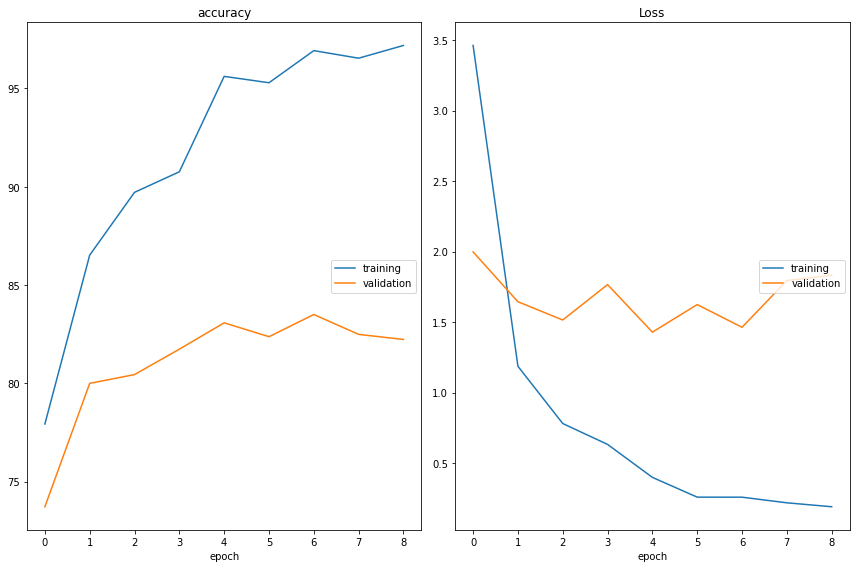

Training model...:  40%|████      | 8/20 [18:48<28:13, 141.08s/it]

accuracy
	training         	 (min:   77.928, max:   97.185, cur:   97.185)
	validation       	 (min:   73.719, max:   83.498, cur:   82.228)
Loss
	training         	 (min:    0.191, max:    3.461, cur:    0.191)
	validation       	 (min:    1.429, max:    1.998, cur:    1.832)
EarlyStopping counter: 4 out of 4
Early stopping


In [60]:
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print([ e.shape  for e in model.fc.parameters()])
model.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model, optimizer, loss_fn, num_epochs)


In [61]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

Validation: 82.41654913023036
Test: 82.82442748091603


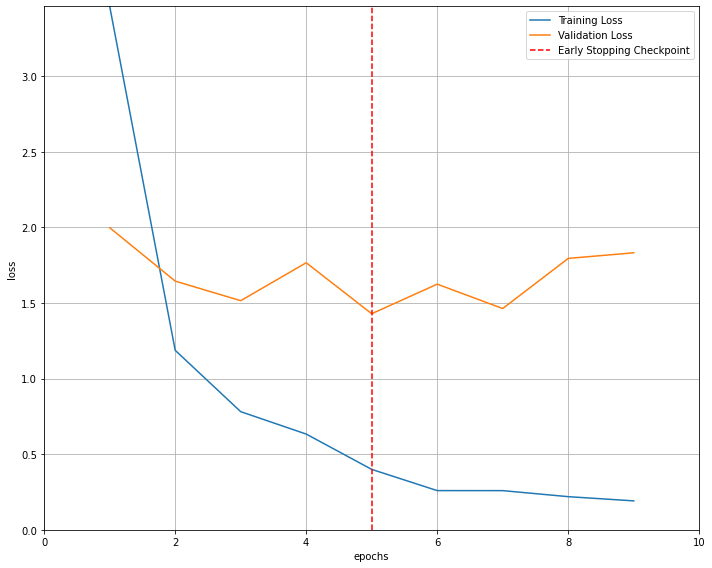

In [62]:
showEarly(loss_lst, val_loss_lst)

#### CNN - SIN CAPA ADICIONAL - BATCH Y DROPOUT PRIMERA CAPA

In [80]:
class CNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
        )
        self.fc = nn.Linear(75*75*32, num_classes) # 64 * 64 * 32 (mask) | 75 * 75 * 32

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [81]:
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print([ e.shape  for e in model.fc.parameters()])
model.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model, optimizer, loss_fn, num_epochs)


[torch.Size([4, 180000]), torch.Size([4])]


Training model...:   0%|          | 0/20 [01:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

In [ ]:
showEarly(loss_lst, val_loss_lst)

### ------------------------------------------------------------------------

## CNN CAPA ADICIONAL

In [38]:
class CNN1(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN1, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 // 2 -> 32 || 75 // 2 -> 37
        )
        self.fc = nn.Linear(37*37*64, num_classes) # 32 * 32 * 32 (mask) | 37 * 37 * 64

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


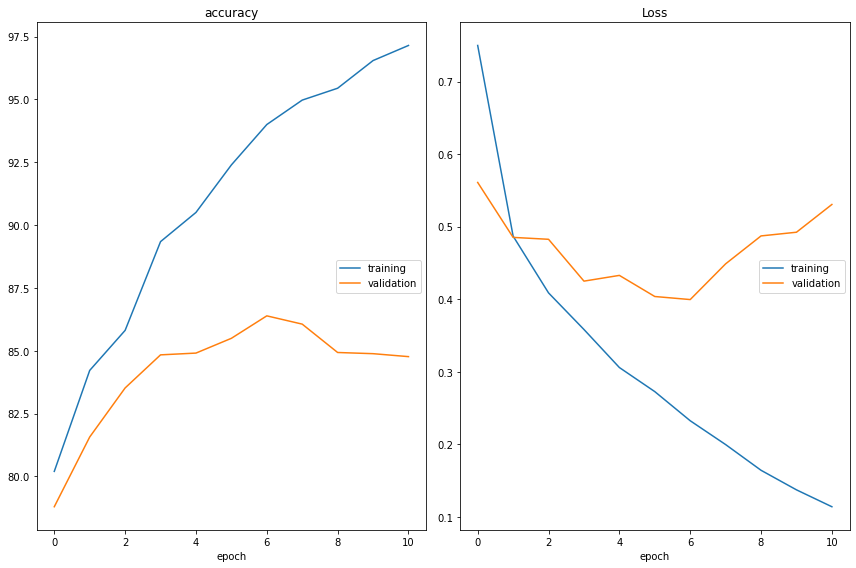

Training model...:  50%|█████     | 10/20 [21:41<21:41, 130.14s/it]

accuracy
	training         	 (min:   80.202, max:   97.145, cur:   97.145)
	validation       	 (min:   78.796, max:   86.389, cur:   84.767)
Loss
	training         	 (min:    0.114, max:    0.750, cur:    0.114)
	validation       	 (min:    0.400, max:    0.561, cur:    0.531)
EarlyStopping counter: 4 out of 4
Early stopping


In [39]:
model1 = CNN1(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
print([ e.shape  for e in model1.fc.parameters()])
model1.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model1, optimizer, loss_fn, num_epochs)

In [40]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

Validation: 86.38928067700988
Test: 85.73473282442748


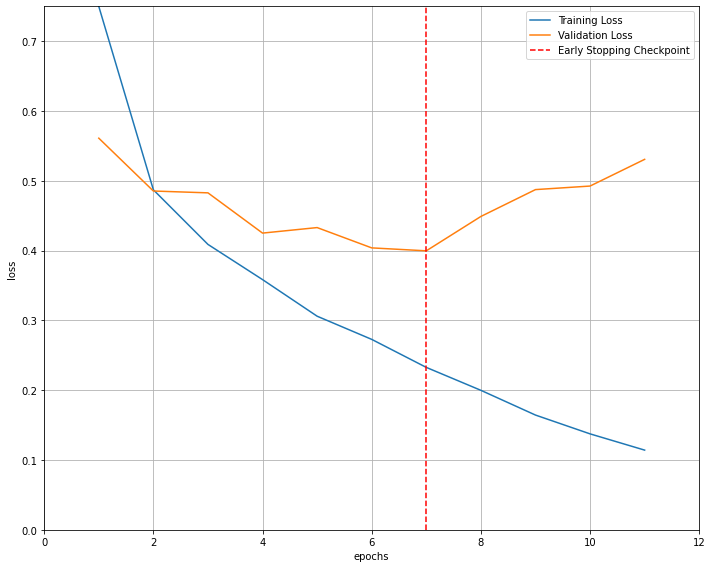

In [41]:
showEarly(loss_lst, val_loss_lst)

## CNN CAPA ADICIONAL - BATCH TODAS LAS CAPAS

In [ ]:
class CNN1(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN1, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 // 2 -> 32 || 75 // 2 -> 37
            nn.BatchNorm2d(64)
        )
        self.fc = nn.Linear(37*37*64, num_classes) # 32 * 32 * 32 (mask) | 37 * 37 * 64

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model1 = CNN1(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
print([ e.shape  for e in model1.fc.parameters()])
model1.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model1, optimizer, loss_fn, num_epochs)

In [ ]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

In [ ]:
showEarly(loss_lst, val_loss_lst)

## CNN CAPA ADICIONAL BATCH Y DROPOUT TODAS LAS CAPAS

In [30]:
class CNN1(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN1, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 // 2 -> 32 || 75 // 2 -> 37
            nn.BatchNorm2d(64)
        )
        self.fc = nn.Linear(37*37*64, num_classes) # 32 * 32 * 32 (mask) | 37 * 37 * 64

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


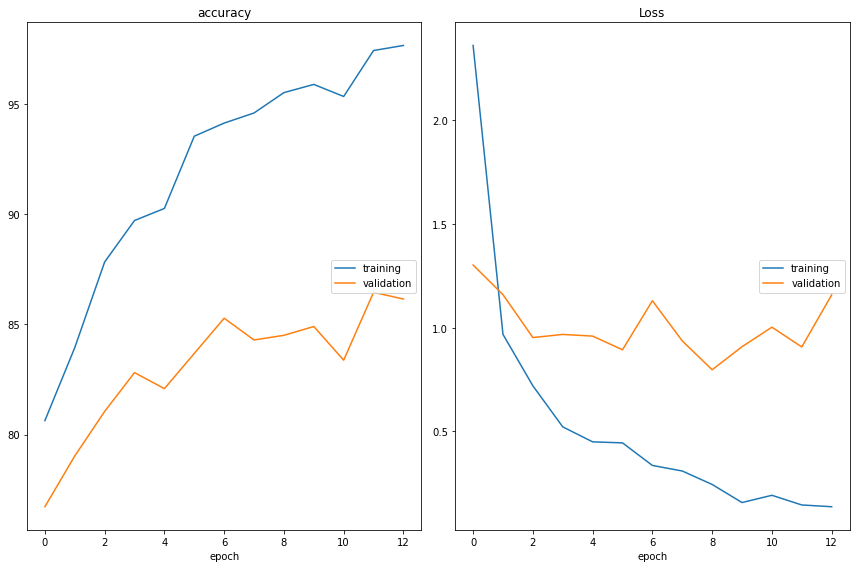

Training model...:  60%|██████    | 12/20 [26:45<17:50, 133.82s/it]

accuracy
	training         	 (min:   80.634, max:   97.665, cur:   97.665)
	validation       	 (min:   76.728, max:   86.460, cur:   86.154)
Loss
	training         	 (min:    0.137, max:    2.361, cur:    0.137)
	validation       	 (min:    0.797, max:    1.303, cur:    1.159)
EarlyStopping counter: 4 out of 4
Early stopping


In [31]:
model1 = CNN1(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
print([ e.shape  for e in model1.fc.parameters()])
model1.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model1, optimizer, loss_fn, num_epochs)

In [32]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

Validation: 84.20310296191819
Test: 83.92175572519083


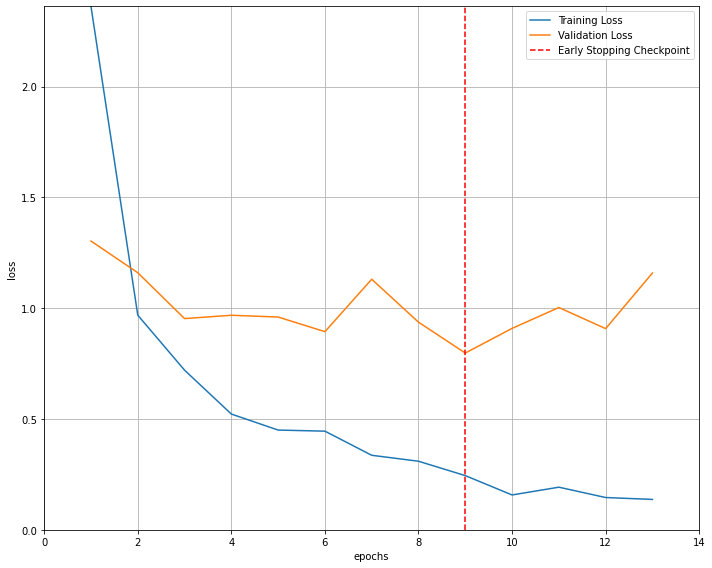

In [33]:
showEarly(loss_lst, val_loss_lst)

## CNN CAPA ADICIONAL BATCH y DROPOUT PRIMERA CAPA

In [34]:
class CNN1(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN1, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 // 2 -> 32 || 75 // 2 -> 37

        )
        self.fc = nn.Linear(37*37*64, num_classes) # 32 * 32 * 32 (mask) | 37 * 37 * 64

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


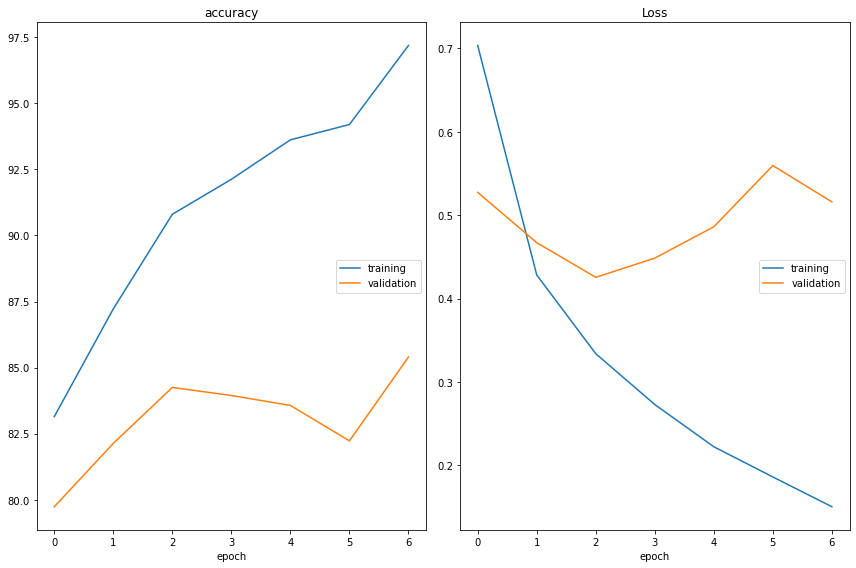

Training model...:  30%|███       | 6/20 [14:31<33:53, 145.27s/it]

accuracy
	training         	 (min:   83.145, max:   97.185, cur:   97.185)
	validation       	 (min:   79.737, max:   85.402, cur:   85.402)
Loss
	training         	 (min:    0.150, max:    0.703, cur:    0.150)
	validation       	 (min:    0.425, max:    0.559, cur:    0.516)
EarlyStopping counter: 4 out of 4
Early stopping


In [35]:
model1 = CNN1(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
print([ e.shape  for e in model1.fc.parameters()])
model1.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model1, optimizer, loss_fn, num_epochs)

In [36]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

Validation: 84.46168312176775
Test: 84.82824427480917


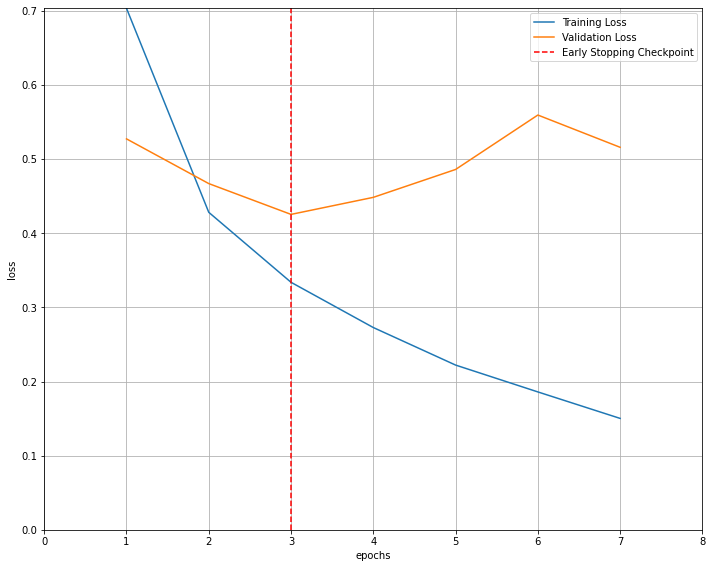

In [37]:
showEarly(loss_lst, val_loss_lst)

# ------------------------------------------------------------------------------

### Dos capas adicionales - sin batch y dropout

In [85]:
class CNN2(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN2, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 129 | 150
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 129 // 2 = 64 (mask) | 75
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 // 2 -> 32 || 75 // 2 -> 37
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size= 3, stride=1, padding=1), # 32 -> 32 | 37 -> 37
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16 -> 16 | 18 -> 18
        )

        self.fc = nn.Linear(18*18*128, num_classes) # 32 * 32 * 32 (mask) | 18 * 18 * 128

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [86]:
model2 = CNN2(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
print([ e.shape  for e in model2.fc.parameters()])
model2.fc.weight

[torch.Size([4, 41472]), torch.Size([4])]


Parameter containing:
tensor([[ 0.0002,  0.0048, -0.0007,  ..., -0.0032,  0.0025, -0.0008],
        [ 0.0041, -0.0001, -0.0018,  ...,  0.0005, -0.0017,  0.0016],
        [-0.0018, -0.0044,  0.0014,  ..., -0.0048, -0.0010,  0.0006],
        [-0.0003,  0.0027,  0.0011,  ...,  0.0024, -0.0005, -0.0019]],
       device='cuda:0', requires_grad=True)

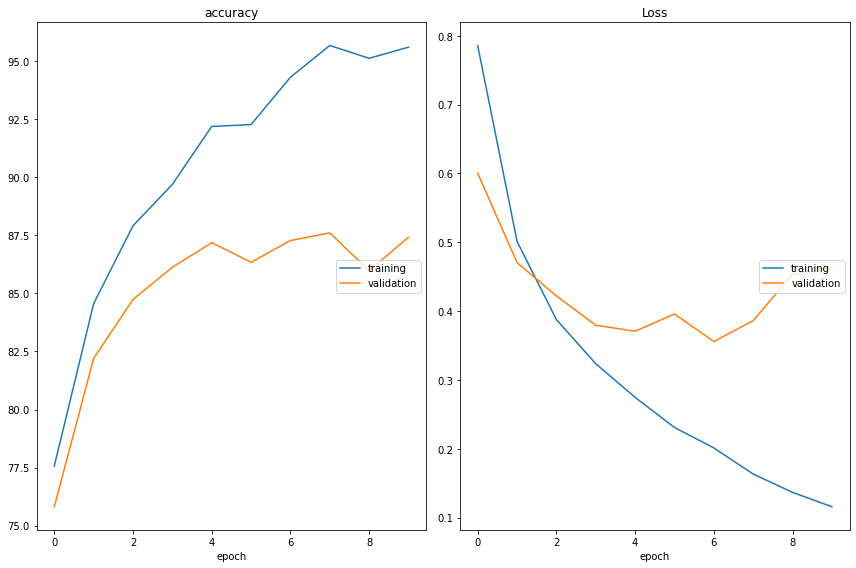

Training model...:  45%|████▌     | 9/20 [20:39<25:14, 137.70s/it]

accuracy
	training         	 (min:   77.563, max:   95.687, cur:   95.613)
	validation       	 (min:   75.811, max:   87.612, cur:   87.424)
Loss
	training         	 (min:    0.116, max:    0.786, cur:    0.116)
	validation       	 (min:    0.356, max:    0.600, cur:    0.463)
EarlyStopping counter: 3 out of 3
Early stopping


In [87]:
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model2, optimizer, loss_fn, num_epochs)

In [88]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")


Validation: 87.28255759285379
Test: 86.45038167938931


In [ ]:
showEarly(loss_lst, val_loss_lst)

### Dos capas adicionales - Agregando batch normalization

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN2, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 // 2 -> 32 || 75 // 2 -> 37
            nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size= 3, stride=1, padding=1), # 32 -> 32 | 37 -> 37
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 16 | 18 -> 18
            nn.BatchNorm2d(128)
        )

        self.fc = nn.Linear(18*18*128, num_classes) # 32 * 32 * 32 (mask) | 18 * 18 * 128

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model2 = CNN2(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
print([ e.shape  for e in model2.fc.parameters()])
model2.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model2, optimizer, loss_fn, num_epochs)

In [ ]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

In [ ]:
showEarly(loss_lst, val_loss_lst)

### Dos capas adicionales - Batch normalization y Dropout en cada capa

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN2, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 // 2 = 64 (mask) | 75
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 // 2 -> 32 || 75 // 2 -> 37
            nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size= 3, stride=1, padding=1), # 32 -> 32 | 37 -> 37
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 16 | 18 -> 18
            nn.BatchNorm2d(128)
        )

        self.fc = nn.Linear(18*18*128, num_classes) # 32 * 32 * 32 (mask) | 18 * 18 * 128

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model2 = CNN2(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
print([ e.shape  for e in model2.fc.parameters()])
model2.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model2, optimizer, loss_fn, num_epochs)

In [ ]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

In [ ]:
showEarly(loss_lst, val_loss_lst)

### Dos capas adicionales - Batch Normalization y Dropout en la primera capa

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN2, self).__init__()
        self.flatten = nn.Flatten() # Reduce cualquier matriz a 1D
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),# 256 -> 258 (mask) 299 -> 301
            nn.Dropout(p = 0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 129 | 150
            nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 129 -> 129 (mask) | 150-> 150
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 129 // 2 = 64 (mask) | 75
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding=1), # 64 -> 64 | 75 -> 75
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 // 2 -> 32 || 75 // 2 -> 37
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size= 3, stride=1, padding=1), # 32 -> 32 | 37 -> 37
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16 -> 16 | 18 -> 18
        )

        self.fc = nn.Linear(18*18*128, num_classes) # 32 * 32 * 32 (mask) | 18 * 18 * 128

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model2 = CNN2(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
print([ e.shape  for e in model2.fc.parameters()])
model2.fc.weight
model_result, loss_lst, val_loss_lst = trainEarlyStopping(model2, optimizer, loss_fn, num_epochs)

In [ ]:
acc_val, acc_test = getAccuracy(model_result, validation_loader), getAccuracy(model_result, test_loader)
print(f"Validation: {acc_val}")
print(f"Test: {acc_test}")

showEarly(loss_lst, val_loss_lst)